## Convolution
The universal approximation theorem states that we can in principle approximate any ground truth function. In practice, this is difficult. We have a powerful optimization method with SGD and momentum, but processing complex data types such as images was historically not really possible until convolution became a thing. Convolution stems from traditional image processing techniques over convolutional kernels (not similar to general kernel functions like the RBF kernels). Instead of defining specific kernels beforehand, convolutional layers allow a network to learn the kernels that fit the specific task and data.   


### 2D Convolution
```{prf:definition}
Given a matrix $X\in\mathbb{R}^{d_h\times d_w}$ representing for example an image. Let $K\in\mathbb{R}^{\kappa\times \kappa}$ be the convolution kernel (filter). The output of a convolution is then defined as the matrix $O\in\mathcal{R}^{d_h-k+1\times d_w-k+1}$ whose entries are given by
\begin{align*}
O_{ij} = (X \star K)_{ij} = \sum_{i_k=0}^{k-1}\sum_{j_k=0}^{k-1} X_{i+i_k,j+j_k} K_{i_k,j_k}
\end{align*}
```

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.animation
from IPython.display import HTML
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cm_0 = LinearSegmentedColormap.from_list("mycmap", ["#ffffff","#a0c3ff"])
cm_1 = LinearSegmentedColormap.from_list("mycmap", ["#ffffff", "#ffa1cf"])
cm_2 = LinearSegmentedColormap.from_list("mycmap", ["#ffffff", "#f37726"])
#####################
# Array preparation
#####################

#input array
a = np.random.randint(1,10, size=(5,5))
# kernel
kernel = np.array([[ 0,-1, 0], [-1, 5,-1], [ 0,-1, 0]])

# visualization array (2 bigger in each direction)
va = np.zeros((a.shape[0], a.shape[1]), dtype=int)
va = a

#output array
res = np.zeros((a.shape[0]-kernel.shape[0]+1,a.shape[1]-kernel.shape[1]+1))

#colorarray
va_color = np.zeros((a.shape[0], a.shape[1])) 

#####################
# Create inital plot
#####################
fig = plt.figure(figsize=(10,5))

def add_axes_inches(fig, rect):
    w,h = fig.get_size_inches()
    return fig.add_axes([rect[0]/(w+2), rect[1]/(h+2), rect[2]/(w+2), rect[3]/(h+2)])

axwidth = 3.
cellsize = axwidth/va.shape[1]
axheight = cellsize*va.shape[0]

ax_va  = add_axes_inches(fig, [cellsize, cellsize, axwidth, axheight])
ax_kernel  = add_axes_inches(fig, [cellsize*2+axwidth,
                                   (2+res.shape[0])*cellsize-kernel.shape[0]*cellsize,
                                   kernel.shape[1]*cellsize,  
                                   kernel.shape[0]*cellsize])
ax_res = add_axes_inches(fig, [cellsize*3+axwidth+kernel.shape[1]*cellsize,
                               2*cellsize, 
                               res.shape[1]*cellsize,  
                               res.shape[0]*cellsize])
ax_kernel.set_title("Kernel", size=12)

im_va = ax_va.imshow(va_color, vmin=0., vmax=1.3, cmap=cm_0)
for i in range(va.shape[0]):
    for j in range(va.shape[1]):
        ax_va.text(j,i, va[i,j], va="center", ha="center")

ax_kernel.imshow(np.zeros_like(kernel), vmin=-1, vmax=1, cmap=cm_2)
for i in range(kernel.shape[0]):
    for j in range(kernel.shape[1]):
        ax_kernel.text(j,i, kernel[i,j], va="center", ha="center")


im_res = ax_res.imshow(res, vmin=0, vmax=1.3, cmap=cm_1)
res_texts = []
for i in range(res.shape[0]):
    row = []
    for j in range(res.shape[1]):
        row.append(ax_res.text(j,i, "", va="center", ha="center"))
    res_texts.append(row)    


for ax  in [ax_va, ax_kernel, ax_res]:
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax.yaxis.set_major_locator(mticker.IndexLocator(1,0))
    ax.xaxis.set_major_locator(mticker.IndexLocator(1,0))
    ax.grid(color="k")

###############
# Animation
###############
def init():
    for row in res_texts:
        for text in row:
            text.set_text("")

def animate(ij):
    i,j=ij
    o = kernel.shape[1]//2
    # calculate result
    res_ij = (kernel*va[i-o+1:1+i+o+1, 1+j-o:1+j+o+1]).sum()
    res_texts[i][j].set_text(res_ij)
    # make colors
    c = va_color.copy()
    c[1+i-o:1+i+o+1, 1+j-o:1+j+o+1] = 1.
    im_va.set_array(c)

    r = res.copy()
    r[i,j] = 1
    im_res.set_array(r)

i,j = np.indices(res.shape)
anim = matplotlib.animation.FuncAnimation(fig, animate, init_func=init, 
                                         frames=zip(i.flat, j.flat), interval=400)
plt.close()
HTML(anim.to_jshtml())

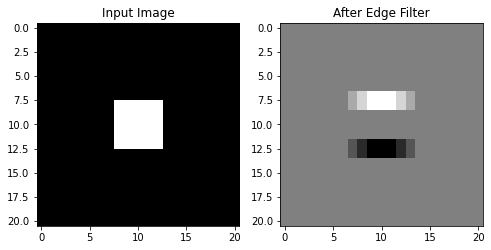

In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Create a simple 7x7 grayscale "image"
image = torch.zeros(1, 1, 21, 21)  # (batch, channels, height, width)
image[0, 0, 8:13, 8:13] = 1.0      # A white square in the center

# Define a simple edge-detection kernel
edge_filter = torch.tensor([[[[-1, -1, -1],
                              [ 0,  0,  0],
                              [ 1,  1,  1]]]], dtype=torch.float32)

# Apply convolution manually
conv = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
conv.weight.data = edge_filter  # Set weights to our kernel
output = conv(image)

# Plot input and output
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(image[0, 0].numpy(), cmap='gray')
axes[0].set_title("Input Image")
axes[1].imshow(output[0, 0].detach().numpy(), cmap='gray')
axes[1].set_title("After Horizontal Edge Filter")
plt.show()


#### Stride and Padding

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.animation
from IPython.display import HTML
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cm_0 = LinearSegmentedColormap.from_list("mycmap", ["#ffffff","#a0c3ff"])
cm_1 = LinearSegmentedColormap.from_list("mycmap", ["#ffffff", "#ffa1cf"])
cm_2 = LinearSegmentedColormap.from_list("mycmap", ["#ffffff", "#f37726"])
#####################
# Array preparation
#####################

#input array
a = np.random.randint(50,150, size=(5,5))
# kernel
kernel = np.array([[ 0,-1, 0], [-1, 5,-1], [ 0,-1, 0]])

# visualization array (2 bigger in each direction)
va = np.zeros((a.shape[0]+2, a.shape[1]+2), dtype=int)
va[1:-1,1:-1] = a

#output array
res = np.zeros_like(a)

#colorarray
va_color = np.zeros((a.shape[0]+2, a.shape[1]+2)) 
va_color[1:-1,1:-1] = 0.5

#####################
# Create inital plot
#####################
fig = plt.figure(figsize=(8,4))

def add_axes_inches(fig, rect):
    w,h = fig.get_size_inches()
    return fig.add_axes([rect[0]/w, rect[1]/h, rect[2]/w, rect[3]/h])

axwidth = 3.
cellsize = axwidth/va.shape[1]
axheight = cellsize*va.shape[0]

ax_va  = add_axes_inches(fig, [cellsize, cellsize, axwidth, axheight])
ax_kernel  = add_axes_inches(fig, [cellsize*2+axwidth,
                                   (2+res.shape[0])*cellsize-kernel.shape[0]*cellsize,
                                   kernel.shape[1]*cellsize,  
                                   kernel.shape[0]*cellsize])
ax_res = add_axes_inches(fig, [cellsize*3+axwidth+kernel.shape[1]*cellsize,
                               2*cellsize, 
                               res.shape[1]*cellsize,  
                               res.shape[0]*cellsize])
ax_kernel.set_title("Kernel", size=12)

im_va = ax_va.imshow(va_color, vmin=0., vmax=1.3, cmap=cm_0)
for i in range(va.shape[0]):
    for j in range(va.shape[1]):
        ax_va.text(j,i, va[i,j], va="center", ha="center")

ax_kernel.imshow(np.zeros_like(kernel), vmin=-1, vmax=1, cmap=cm_2)
for i in range(kernel.shape[0]):
    for j in range(kernel.shape[1]):
        ax_kernel.text(j,i, kernel[i,j], va="center", ha="center")


im_res = ax_res.imshow(res, vmin=0, vmax=1.3, cmap=cm_1)
res_texts = []
for i in range(res.shape[0]):
    row = []
    for j in range(res.shape[1]):
        row.append(ax_res.text(j,i, "", va="center", ha="center"))
    res_texts.append(row)    


for ax  in [ax_va, ax_kernel, ax_res]:
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax.yaxis.set_major_locator(mticker.IndexLocator(1,0))
    ax.xaxis.set_major_locator(mticker.IndexLocator(1,0))
    ax.grid(color="k")

###############
# Animation
###############
def init():
    for row in res_texts:
        for text in row:
            text.set_text("")

def animate(ij):
    i,j=ij
    o = kernel.shape[1]//2
    # calculate result
    res_ij = (kernel*va[1+i-o:1+i+o+1, 1+j-o:1+j+o+1]).sum()
    res_texts[i][j].set_text(res_ij)
    # make colors
    c = va_color.copy()
    c[1+i-o:1+i+o+1, 1+j-o:1+j+o+1] = 1.
    im_va.set_array(c)

    r = res.copy()
    r[i,j] = 1
    im_res.set_array(r)

i,j = np.indices(res.shape)
anim = matplotlib.animation.FuncAnimation(fig, animate, init_func=init, 
                                         frames=zip(i.flat, j.flat), interval=400)
plt.close()
HTML(anim.to_jshtml())

### Inductive Bias
CNNs have very strong inductive biases, that are assumptions about how data should be processed and how it is structured. These assumptions made automatic processing of images with machine learning possible, and hence, the inductive bias of CNNs is a core topic in theory and practice. For example, the introduction of convolution meant that CNNs don't need to learn from scratch that an edge is still an edge if it moves 10 pixels to the right.

Generally, an inductive bias is a built-in assumption that guides a learning algorithm toward certain types of solutions. It describes mainly design choices that push a model towards specific outputs that we deem more useful. For example, the assumption that a regression model only needs a subset of the available feature is an inductive bias in sparse regression models. 

In convolutional neural networks (CNNs), the inductive biases are:

 - Locality: Nearby pixels form patterns that may be useful for the task.

 - Translation equivariance: If the input shifts, the output shifts accordingly (i.e., features are detected regardless of position).

 - Parameter sharing: The same filter (set of weights) is used across the whole image, reducing the number of parameters.

These assumptions make CNNs particularly effective for tasks with grid-structured data (e.g., images, video, audio spectrograms).